<a href="https://colab.research.google.com/github/deepanshu2506/traffic-sign-detection/blob/main/Traffic_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import Model
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [ ]:
!unzip "/content/drive/My Drive/D1/traffic_jpg" -d "/content/data"
!unzip "/content/drive/My Drive/D1/traffic in jpg/FullIJCNN2013/backgroundImages.zip" -d "/content/data/content/FullIJCNN2013/"
!unzip "/content/drive/My Drive/D1/traffic in jpg/FullIJCNN2013/digit.zip" -d '/content/data/content/FullIJCNN2013'

In [ ]:
ANNOTATIONS_FILE = "/content/drive/My Drive/D1/gt.csv"
DATASET_ROOT = '/content/data/content/FullIJCNN2013'
MODEL_ROOT= "/content/drive/My Drive/D1"


In [ ]:
annotations = pd.read_csv(ANNOTATIONS_FILE , sep=';',header=None)

In [ ]:
for i in range len(annotations):
    bb = annotations.iloc[i]
    filename = bb[0].split(".")[0]
    im =cv2.imread(DATASET + "/" + filename + ".jpg")[bb[2]:bb[4] , bb[1]:bb[3]]
    cv2.imwrite(DATASET_ROOT+'/'+"%02d"%bb[5]+"/"+filename+str(bb[3]) +".jpg" , im)


In [ ]:

classes = ["%02d"%i for i in range(0 , 43)]
classes.append("background")

feature_train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

feature_train_generator = feature_train_datagen.flow_from_directory(
    DATASET_ROOT, 
        target_size=(48,48),  
        batch_size=16,
        class_mode='categorical',subset='training')

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    DATASET_ROOT, 
        target_size=(48,48),  
        batch_size=16,
        classes=classes,
        class_mode='categorical',subset='training')


hidden_num_units = 512
hidden_num_units1 = 256

conv_training_outputs =53 + 1

fine_tuning_outputs = 43 + 1

coarse_training_epochs = 5 #100 in paper
fine_tuning_epochs = 50 
batch_size = 32
pool_size = (2, 2)
class_labels = dict([(value, key) for key, value in train_generator.class_indices.items()]) 


Found 44212 images belonging to 54 classes.
Found 2212 images belonging to 44 classes.


In [ ]:

inputs = keras.Input(shape=(48,48,3) , name='roi_images')

x = Conv2D(100, (5, 5), activation='relu')(inputs)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Conv2D(150, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Conv2D(250, (3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)
x = Flatten()(x)
x =  Dense(units=hidden_num_units, activation='relu')(x)
conv_layers_output =  Dense(units=hidden_num_units1 , input_dim=hidden_num_units , activation='relu')(x)
conv_model = Model(inputs=inputs , outputs=conv_layers_output , name='conv_encoding')

conv_model.summary()

In [ ]:
# training loop
inputs = keras.Input(shape=(48,48,3) , name='roi_images')
x = conv_model(inputs)
outputs =  Dense(units=output_num_units, input_dim=hidden_num_units1, activation='softmax')(x)
coarse_trained_model = Model(inputs=inputs , outputs = outputs , name="feature_training")
coarse_trained_model.summary()
coarse_trained_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
trained_model_conv = coarse_trained_model.fit(feature_train_generator, epochs=coarse_training_epochs, steps_per_epoch=feature_train_generator.samples // batch_size )     
                              

In [ ]:
# fine tuning loop
conv_model.trainable = False
inputs = keras.Input(shape=(48,48,3) , name='roi_images')
x = conv_model(inputs)
outputs =  Dense(units=len(classes), input_dim=hidden_num_units1, activation='softmax')(x)
fine_tuned_model = Model(inputs=inputs , outputs = outputs , name="fine_tuning")
fine_tuned_model.summary()
fine_tuned_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])
history = fine_tuned_model.fit(train_generator, epochs=fine_tuning_epochs, steps_per_epoch=train_generator.samples // batch_size )     


In [ ]:
model_json = fine_tuned_model.to_json()
with open(MODEL_ROOT + "/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
fine_tuned_model.save_weights(MODEL_ROOT+"/model.h5")
print("Saved model to disk")

Saved model to disk


[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['02']


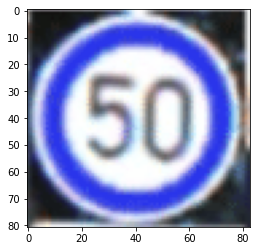

In [ ]:
image = cv2.imread('/content/test.png')
plt.imshow(image)
image = np.array([cv2.resize(image , (48,48))])
prediction = fine_tuned_model.predict(image)
print(prediction)
most_likely_class = np.argmax(prediction , axis=1)
print([class_labels[sample] for sample in most_likely_class])

In [ ]:
test_x = []
test_y = []
print("loading "+str(len(annotations))+" test samples")
for i in range(len(annotations)):
    bb = annotations.iloc[i]
    filename = bb[0].split(".")[0]
    im =cv2.imread(DATASET_ROOT + "/" + filename + ".jpg")[bb[2]:bb[4] , bb[1]:bb[3]]
    im = cv2.resize(im,(48,48))
    test_x.append(im)
    y = np.zeros(len(classes))
    y[bb[5]] = 1
    test_y.append(y)
    if(i % 50 == 0):
        print("=" , end="")
print()
print("done loading")
test_x = np.array(test_x)
test_y = np.array(test_y)





NameError: ignored

In [ ]:
results = fine_tuned_model.evaluate(test_x, test_y, batch_size=128)
print("test loss, test acc:", results)

10/10 [==============================] - 4s 422ms/step - loss: 68.4078 - accuracy: 0.6595
test loss, test acc: [68.40776824951172, 0.6595218181610107]


In [ ]:
json_file = open(MODEL_ROOT +'/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_ROOT + "/model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])


Loaded model from disk


In [ ]:
score = loaded_model.evaluate(test_x, test_y)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
import random
import math
image = cv2.imread(DATASET_ROOT + "/00027.jpg")
print()
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
print('starting')
rects = ss.process()
print("done")





starting
done


In [ ]:
ROI = []
bounding_boxes = []
(W_high , W_low) = (100 , 30)
(H_high , H_low) = (100 , 30)
W_H_diff = 30
for i in range(0, len(rects), 100):
    for (x, y, w, h) in rects[i:i + 100]:
        if(w > W_low and w < W_high and h < H_high and h > H_low and abs(w-h) < W_H_diff ):
            ROI.append(cv2.resize(image[y:y+h , x:x+h] , (48,48)))
            bounding_boxes.append((x,y,w,h))
print(len(ROI))

1540


In [ ]:
preds = loaded_model.predict(np.array(ROI))
preds = np.argmax(preds , axis=1)
print(len(preds))

1540


In [ ]:
output_preds = []
output_bbs = []
for i in range(len(preds)):
    if class_labels[preds[i]] != "background":
        output_bbs.append(bounding_boxes[i])
        output_preds.append(preds[i])
print("output bounding boxes = " , len(output_bbs))

output bounding boxes =  69


In [ ]:
print(len(output_preds))
selected_indices = tf.image.non_max_suppression(
    output_bbs, output_preds, 40, 0.85)
print(len(selected_indices))

69
31


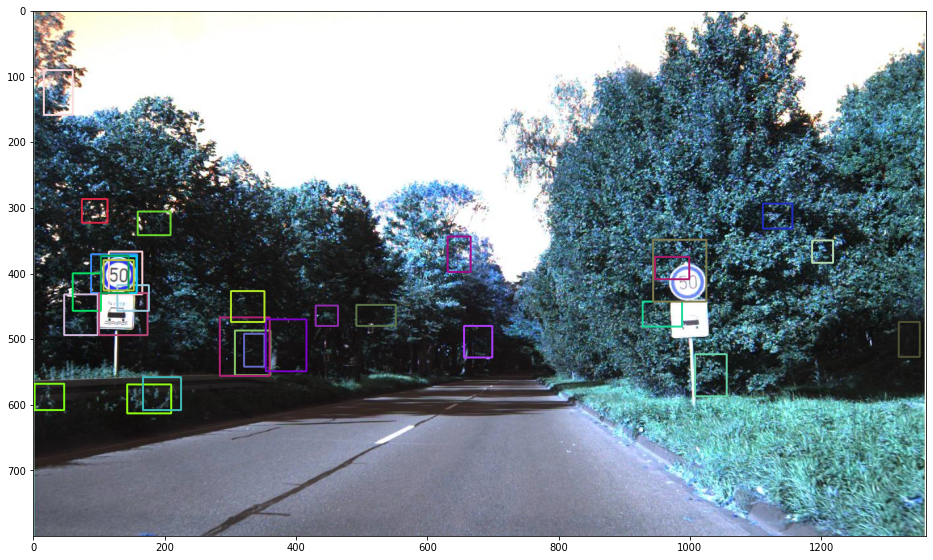

In [ ]:
output = image.copy()

for idx  in selected_indices:
    x,y,w,h = output_bbs[idx]
    color = [random.randint(0, 255) for j in range(0, 3)]
    cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)

plt.figure(figsize=(16,16))
plt.imshow(output)
